<a href="https://colab.research.google.com/github/FarrazNouval/Python-for-production-and-operation-management/blob/main/loading_problem_in_scheduling/assignment_method.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

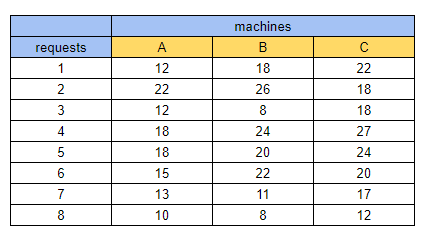

The image above is a table that shows how long each machine takes to complete each request. And the problem is figuring out how to assign each request to machines so that we can complete them all effectively and efficiently.

In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import linear_sum_assignment

In [2]:
arr = [
    [12, 18, 22],
    [22, 26, 18],
    [12, 8, 18],
    [18, 24, 27],
    [18, 20, 24],
    [15, 22, 20],
    [13, 11, 17],
    [10, 8, 12]
    ]

x = np.array(arr)


Let's try to solve it by hand.
1. Determine the maximum and actual work times (start from zero).
2. Examine each request (row) to find which machine can do it the fastest.
3. Add up the actual and minimal work hours in that row.
4. Save the sum if it is less than or equal to the maximum work time.
5. If the sum is greater than the maximum work time, check the second faster, and so on.



In [3]:
# declare the maximum work time
max_time = 40

# declare the actual work time
times = {'1':0.0,
         '2':0.0,
         '3':0.0}

# declare the variable to save the request and machine combination
machines = {'1':[],
            '2':[],
            '3':[]}

for i in range(len(x)):

  while True:
    row_elements = x[i] # capture times to finish the request
    min_idx = np.argmin(row_elements) # capture the index of the minimum time (capture the machine)

    # check if the sum is lower than or equal to max work time
    if row_elements[min_idx] + times[str(min_idx + 1)] <= max_time:
      # if true sum up actual work time and work time
      times[str(min_idx + 1)] += row_elements[min_idx]
      # append the request number to the machine
      machines[str(min_idx + 1)].append(i + 1)
      break

    else:
      # if the sum is higher than max work time
      row_elements[min_idx] = 999 # change the work time to 999 so we can find the next faster time


In [4]:
times


{'1': 40.0, '2': 39.0, '3': 38.0}

In [5]:
machines

{'1': [1, 4, 8], '2': [3, 5, 7], '3': [2, 6]}

Now let's solve it using the OOP approach.

In [10]:
class SeriesAssignment():
    """
    Create a recommendation to discover the best combination of demands and executors at the lowest cost.

    constructor:
        arr : array of costs or time that the executor requires to finish the request or demand.
    """
    def __init__(self, cost_array):
        self.cost_array = np.array(cost_array)

    def execute(self):
        """
        Returns:
            demand number (index): list
            list of demand or request indexes, starting from 0

            executor number (index): list
            list of executor indexes, starting from 0

            total_cost : int
            Total cost or time required for executors to complete requests or demands
        """
        demand_ind, executor_ind = linear_sum_assignment(self.cost_array)

        for i, j in zip(demand_ind, executor_ind):
            print(f"demand {i} => executor {j}")

        total_cost = self.cost_array[demand_ind, executor_ind].sum()
        print(f"Total cost : {total_cost}")

        return demand_ind, executor_ind, total_cost

class ParallelAssignment():
    """
    Create a recommendation to discover the best combination of demands and executors at the lowest cost.

    constructor:
        arr : array of costs or time that the executor requires to finish the request or demand.
        max_time : max time or cost of execution.
    """
    def __init__(self, arr, max_time):
        self.arr = arr
        self.arr_cp = arr.copy()
        self.max_time = max_time
        self.times = {str(i + 1):0 for i in range(arr.shape[1])} # executor total work time (cost)
        self.times_arr = {str(i + 1):[] for i in range(arr.shape[1])} # execution times (costs) list
        self.machines = {str(i + 1):[] for i in range(arr.shape[1])} # executors work list

    def execute(self):
        """
        Distribute demands among executors efficiently (with less labor time or cost) while remaining within the time or cost limit.
        """
        for i in range(len(self.arr_cp)):
            while True:
                row_elements = self.arr_cp[i] # capture the row elements
                min_idx = np.argmin(row_elements) # get the index (executor) of the lower cost

                # if the executor with the min_idx total times + min_idx times is less than max _time
                if row_elements[min_idx] + self.times[str(min_idx + 1)] <= self.max_time:
                    # add total executor times (works)
                    self.times[str(min_idx + 1)] += row_elements[min_idx]
                    # capture the execution time (cost) and append it to executor times (cost) array
                    self.times_arr[str(min_idx + 1)].append(row_elements[min_idx])
                    # capture the request (demand) and append it to machines work list
                    self.machines[str(min_idx + 1)].append(i + 1)
                    break

                else:
                    row_elements[min_idx] = 99999999
                    break

    def show_times_table(self):

        # capture the max length of column's elements
        lengths = []
        for i in self.times_arr.keys():
            lengths.append(len(self.times_arr[i]))

        lengths = np.array(lengths)
        max_elements_lengths = lengths[np.argmax(lengths)]


        # if there is a column with length is lower than max length
        # fill with 0 till it's length is equal to max length
        for i in self.times_arr.keys():
            if len(self.times_arr[i]) < max_elements_lengths:
                gap = max_elements_lengths - len(self.times_arr[i])
                for j in range(gap):
                    self.times_arr[i].append(0)

        times_table = pd.DataFrame(self.times_arr)
        times_table.index = [''] * len(times_table)
        total_times = pd.DataFrame(self.times, index=["Total"])
        times_table = pd.concat([times_table, total_times], axis=0)
        times_table.columns = times_table.columns.map(lambda x: "machine " + x)

        return times_table

    def show_machines_table(self):
        # machines table
        lengths = []
        for i in self.machines.keys():
            lengths.append(len(self.machines[i]))

        lengths = np.array(lengths)
        max_elements_length = lengths[np.argmax(lengths)]

        for i in self.machines.keys():
            if len(self.machines[i]) < max_elements_length:
                gap = max_elements_length - len(self.machines[i])
                for j in range(gap):
                    self.machines[i].append(0)

        machine_table = pd.DataFrame(self.machines)
        machine_table.columns = machine_table.columns.map(lambda x: "machine " + x)
        machine_table.index = [''] * len(machine_table)

        return machine_table

In [7]:
testing = ParallelAssignment(x, 40)
testing.execute()


In [8]:
testing.show_times_table()

,machine 1,machine 2,machine 3
,12,8,18
,18,20,20
,10,11,0
Total,40,39,38


In [9]:
testing.show_machines_table()


,machine 1,machine 2,machine 3
,1,3,2
,4,5,6
,8,7,0


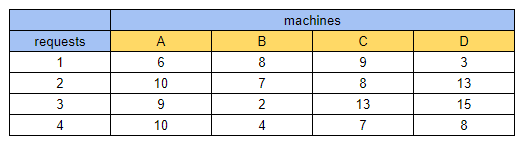

The image above is a table that shows how much each machine costs to complete each request. And the problem is figuring out how to assign each request to machines so that we can complete them all effectively and efficiently.

conditions that must be met:
1. The number of machines must be equal to the number of requests.
2. One machine can only finish one request.




In [12]:
arr_2 = np.array([[6, 8, 9, 3],
                  [10, 7, 8, 13],
                  [9, 2, 13, 15],
                  [10, 4, 7, 8]])


In [13]:
problem2 = SeriesAssignment(arr_2)
demand_ind, executor_ind, total_cost = problem2.execute()


demand 0 => executor 3
demand 1 => executor 0
demand 2 => executor 1
demand 3 => executor 2
Total cost : 22
